<a href="https://colab.research.google.com/github/woodstone10/vision-image-video-lab/blob/main/MNIST_tf_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Image MNIST (0~9) classification using CNN deep learning


---





In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [ ]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


Data from MNIST (black-and-white 2D image)
In this sample, we will be using the MNIST dataset, which is a set of 70,000 small images of digits handwritten by high school students and employees of the US Census Bureau. Each image is labeled with the digit it represents. This set has been studied so much that it is often called the “Hello World” of Machine Learning: whenever people come up with a new classification algorithm

In [ ]:
MNIST = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = MNIST.load_data()

11493376/11490434 [==============================] - 0s 0us/step


In [ ]:
x_train.shape

(60000, 28, 28)

In [ ]:
y_train.shape

(60000,)

In [ ]:
x_test.shape

(10000, 28, 28)

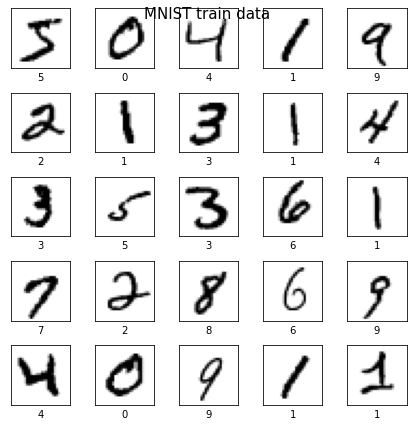

In [ ]:
class_names = ["0","1","2","3","4","5","6","7","8","9"]
plt.figure(figsize=(6,6))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[y_train[i]])
plt.suptitle('MNIST train data', fontsize=15)
plt.tight_layout()
plt.savefig('ML_DeepLearning_ImageClassification_MNIST_data.png')
plt.show()

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 (=784) pixels, and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black).

Scaling (0 ~ 255) >> (0 ~ 1)

In [ ]:
x_train = x_train.reshape(x_train.shape[0], 784).astype(float)/255
x_test = x_test.reshape(x_test.shape[0], 784).astype(float)/255
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

Conventional fully connected Neural network

In [ ]:
model = \
    tf.keras.Sequential([
        tf.keras.layers.Dense(512, input_dim=784, activation='relu'), # input node 784 (25x25)
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax') # classify 10 classes (0~9)
    ])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               401920    
_________________________________________________________________
dense_1 (Dense)              (None, 256)               131328    
_________________________________________________________________
dense_2 (Dense)              (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


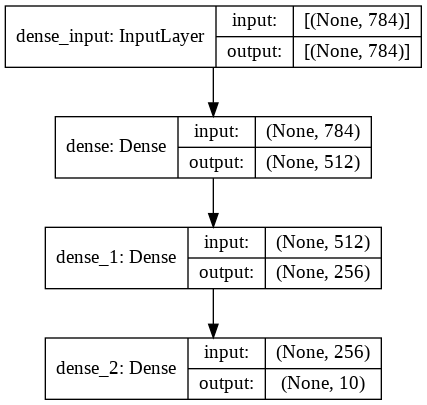

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy', # loss function is cross entropy
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
with tf.device('/device:GPU:0'):
  FC = model.fit(x_train, y_train, # image, label
                 validation_split=0.3, # split data into train (70%) and validation (30%)
                 epochs=30, batch_size=200,
                 verbose=2 # verbose 0: silence, 1: progressbar, 2: oneline acc, loss
                 )

Epoch 1/30
210/210 - 4s - loss: 0.3087 - accuracy: 0.9123 - val_loss: 0.1556 - val_accuracy: 0.9539
Epoch 2/30
210/210 - 1s - loss: 0.1108 - accuracy: 0.9662 - val_loss: 0.1183 - val_accuracy: 0.9633
Epoch 3/30
210/210 - 1s - loss: 0.0676 - accuracy: 0.9790 - val_loss: 0.1006 - val_accuracy: 0.9699
Epoch 4/30
210/210 - 1s - loss: 0.0452 - accuracy: 0.9863 - val_loss: 0.0917 - val_accuracy: 0.9730
Epoch 5/30
210/210 - 1s - loss: 0.0299 - accuracy: 0.9908 - val_loss: 0.0863 - val_accuracy: 0.9757
Epoch 6/30
210/210 - 1s - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.1018 - val_accuracy: 0.9717
Epoch 7/30
210/210 - 1s - loss: 0.0168 - accuracy: 0.9946 - val_loss: 0.1033 - val_accuracy: 0.9719
Epoch 8/30
210/210 - 1s - loss: 0.0139 - accuracy: 0.9957 - val_loss: 0.1048 - val_accuracy: 0.9723
Epoch 9/30
210/210 - 1s - loss: 0.0109 - accuracy: 0.9969 - val_loss: 0.1013 - val_accuracy: 0.9741
Epoch 10/30
210/210 - 1s - loss: 0.0083 - accuracy: 0.9979 - val_loss: 0.1006 - val_accuracy: 0.9764

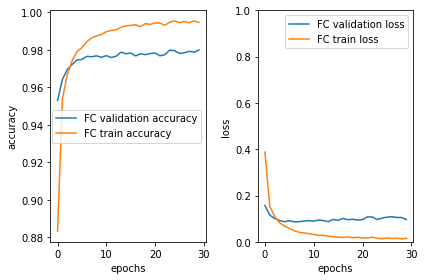

In [ ]:
# Learning curve
plt.subplot(1, 2, 1)
plt.plot(np.arange((len(FC.history['val_accuracy']))), FC.history['val_accuracy'], label='FC validation accuracy')
plt.plot(np.arange((len(FC.history['accuracy']))), FC.history['accuracy'], label='FC train accuracy')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(1, 2, 2)
plt.plot(np.arange((len(FC.history['val_loss']))), FC.history['val_loss'], label='FC validation loss')
plt.plot(np.arange((len(FC.history['loss']))), FC.history['loss'], label='FC train loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.gca().set_ylim(0,1)
plt.tight_layout()
plt.show()


Overfitting observed! it can be solved by dropout

In [ ]:
model = \
    tf.keras.Sequential([
        tf.keras.layers.Dense(512, input_dim=784, activation='relu'), # input node 784 (25x25)
        tf.keras.layers.Dropout(0.3), # for reduce overfitting
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(256, activation='relu'),
        tf.keras.layers.Dropout(0.3), # for reduce overfitting
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(10, activation='softmax') # classify 10 classes (0~9)
    ])

model.compile(loss='categorical_crossentropy', # loss function is cross entropy
              optimizer='adam',
              metrics=['accuracy'])

with tf.device('/device:GPU:0'):
  FC = model.fit(x_train, y_train, # image, label
                 validation_split=0.3, # split data into train (70%) and validation (30%)
                 epochs=30, batch_size=200,
                 verbose=2 # verbose 0: silence, 1: progressbar, 2: oneline acc, loss
                 )

Epoch 1/30
210/210 - 2s - loss: 0.3318 - accuracy: 0.8975 - val_loss: 0.2102 - val_accuracy: 0.9541
Epoch 2/30
210/210 - 1s - loss: 0.1381 - accuracy: 0.9578 - val_loss: 0.1126 - val_accuracy: 0.9666
Epoch 3/30
210/210 - 1s - loss: 0.1029 - accuracy: 0.9689 - val_loss: 0.0977 - val_accuracy: 0.9720
Epoch 4/30
210/210 - 1s - loss: 0.0822 - accuracy: 0.9740 - val_loss: 0.0911 - val_accuracy: 0.9733
Epoch 5/30
210/210 - 1s - loss: 0.0699 - accuracy: 0.9774 - val_loss: 0.0925 - val_accuracy: 0.9738
Epoch 6/30
210/210 - 1s - loss: 0.0626 - accuracy: 0.9793 - val_loss: 0.0871 - val_accuracy: 0.9748
Epoch 7/30
210/210 - 1s - loss: 0.0522 - accuracy: 0.9824 - val_loss: 0.0896 - val_accuracy: 0.9761
Epoch 8/30
210/210 - 1s - loss: 0.0470 - accuracy: 0.9843 - val_loss: 0.0834 - val_accuracy: 0.9762
Epoch 9/30
210/210 - 1s - loss: 0.0462 - accuracy: 0.9848 - val_loss: 0.0887 - val_accuracy: 0.9758
Epoch 10/30
210/210 - 1s - loss: 0.0407 - accuracy: 0.9863 - val_loss: 0.0870 - val_accuracy: 0.9770

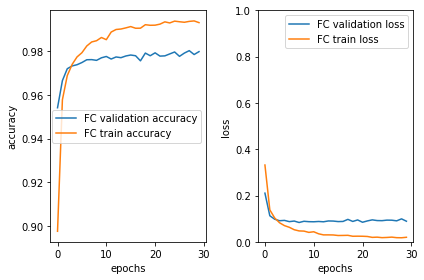

In [ ]:
# Learning curve
plt.subplot(1, 2, 1)
plt.plot(np.arange((len(FC.history['val_accuracy']))), FC.history['val_accuracy'], label='FC validation accuracy')
plt.plot(np.arange((len(FC.history['accuracy']))), FC.history['accuracy'], label='FC train accuracy')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(1, 2, 2)
plt.plot(np.arange((len(FC.history['val_loss']))), FC.history['val_loss'], label='FC validation loss')
plt.plot(np.arange((len(FC.history['loss']))), FC.history['loss'], label='FC train loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.gca().set_ylim(0,1)
plt.tight_layout()
plt.show()

Could not see significant improvement even though dropout and batch normalization

CNN (Convolutional Neural Network)

In [ ]:
(x_train, y_train), (x_test, y_test) = MNIST.load_data()
x_train = x_train.reshape(x_train.shape[0], 28, 28, 1).astype('float32')/255
x_test = x_test.reshape(x_test.shape[0], 28, 28, 1).astype('float32')/255
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

In [ ]:
model = \
    tf.keras.Sequential([
        # tf.keras.layers.Conv2D(
        #     filters, kernel_size, strides=(1, 1), padding='valid',
        #     data_format=None, dilation_rate=(1, 1), groups=1, activation=None,
        #     use_bias=True, kernel_initializer='glorot_uniform',
        #     bias_initializer='zeros', kernel_regularizer=None,
        #     bias_regularizer=None, activity_regularizer=None, kernel_constraint=None,
        #     bias_constraint=None, **kwargs
        # )
        # 26x26, 32
        tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), strides=(1,1), 
                               input_shape=(28, 28, 1), activation='relu'),
        # 24x24, 64
        tf.keras.layers.Conv2D(64, (3,3), (1,1), activation='relu'),
        # 12x12, 64
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.25),
        # 2D -> 1D
        tf.keras.layers.Flatten(),
        # FC
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        # classify to 10 classes
        tf.keras.layers.Dense(10, activation='softmax')
    ])
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_11 (Dense)             (None, 128)               1179776   
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)              

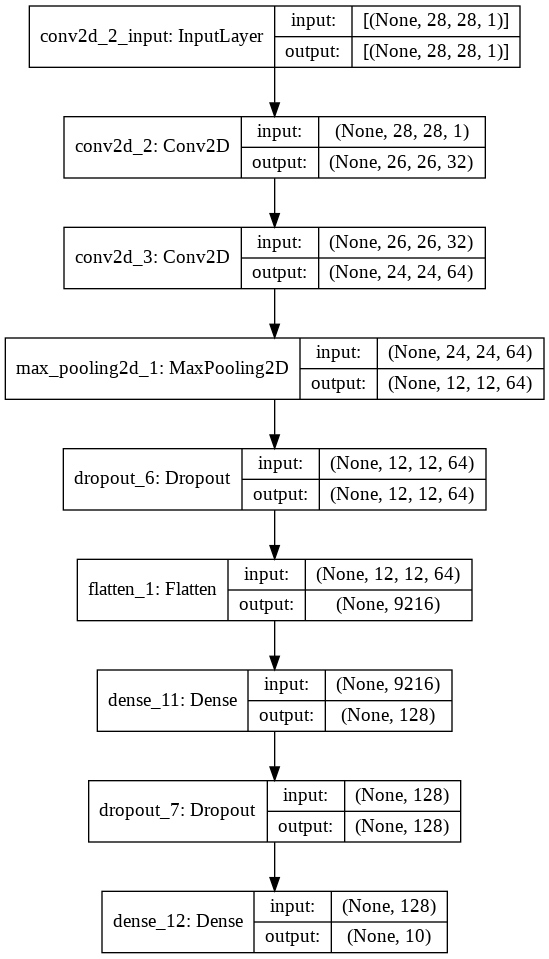

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

CNN uses orignal 2D image data - 4 tensors (batch, width, height, channel)

In [ ]:
x_train.shape

(60000, 28, 28, 1)

In [ ]:
CNN = model.fit(x_train, y_train,
                validation_split=0.3,
                epochs=30,
                batch_size=200,
                verbose=2 # verbose 0: silence, 1: progressbar, 2: oneline acc, loss
                )

Epoch 1/30
210/210 - 5s - loss: 0.1011 - accuracy: 0.9704 - val_loss: 0.0537 - val_accuracy: 0.9837
Epoch 2/30
210/210 - 4s - loss: 0.0754 - accuracy: 0.9777 - val_loss: 0.0469 - val_accuracy: 0.9862
Epoch 3/30
210/210 - 5s - loss: 0.0634 - accuracy: 0.9805 - val_loss: 0.0494 - val_accuracy: 0.9849
Epoch 4/30
210/210 - 5s - loss: 0.0552 - accuracy: 0.9835 - val_loss: 0.0449 - val_accuracy: 0.9868
Epoch 5/30
210/210 - 4s - loss: 0.0500 - accuracy: 0.9843 - val_loss: 0.0418 - val_accuracy: 0.9878
Epoch 6/30
210/210 - 4s - loss: 0.0452 - accuracy: 0.9862 - val_loss: 0.0414 - val_accuracy: 0.9884
Epoch 7/30
210/210 - 4s - loss: 0.0397 - accuracy: 0.9874 - val_loss: 0.0394 - val_accuracy: 0.9880
Epoch 8/30
210/210 - 4s - loss: 0.0352 - accuracy: 0.9886 - val_loss: 0.0389 - val_accuracy: 0.9890
Epoch 9/30
210/210 - 4s - loss: 0.0352 - accuracy: 0.9882 - val_loss: 0.0378 - val_accuracy: 0.9894
Epoch 10/30
210/210 - 4s - loss: 0.0318 - accuracy: 0.9897 - val_loss: 0.0421 - val_accuracy: 0.9889

In [ ]:
with tf.device('/device:GPU:0'):
  CNN = model.fit(x_train, y_train,
                  validation_split=0.3,
                  epochs=30,
                  batch_size=200,
                  verbose=2 # verbose 0: silence, 1: progressbar, 2: oneline acc, loss
                  )

Epoch 1/30
210/210 - 5s - loss: 0.0131 - accuracy: 0.9953 - val_loss: 0.0470 - val_accuracy: 0.9908
Epoch 2/30
210/210 - 4s - loss: 0.0133 - accuracy: 0.9959 - val_loss: 0.0526 - val_accuracy: 0.9898
Epoch 3/30
210/210 - 4s - loss: 0.0120 - accuracy: 0.9958 - val_loss: 0.0515 - val_accuracy: 0.9897
Epoch 4/30
210/210 - 4s - loss: 0.0129 - accuracy: 0.9955 - val_loss: 0.0484 - val_accuracy: 0.9904
Epoch 5/30
210/210 - 4s - loss: 0.0121 - accuracy: 0.9956 - val_loss: 0.0480 - val_accuracy: 0.9903
Epoch 6/30
210/210 - 4s - loss: 0.0102 - accuracy: 0.9963 - val_loss: 0.0487 - val_accuracy: 0.9903
Epoch 7/30
210/210 - 4s - loss: 0.0117 - accuracy: 0.9959 - val_loss: 0.0482 - val_accuracy: 0.9907
Epoch 8/30
210/210 - 4s - loss: 0.0108 - accuracy: 0.9961 - val_loss: 0.0474 - val_accuracy: 0.9908
Epoch 9/30
210/210 - 4s - loss: 0.0099 - accuracy: 0.9961 - val_loss: 0.0505 - val_accuracy: 0.9907
Epoch 10/30
210/210 - 4s - loss: 0.0134 - accuracy: 0.9952 - val_loss: 0.0518 - val_accuracy: 0.9901

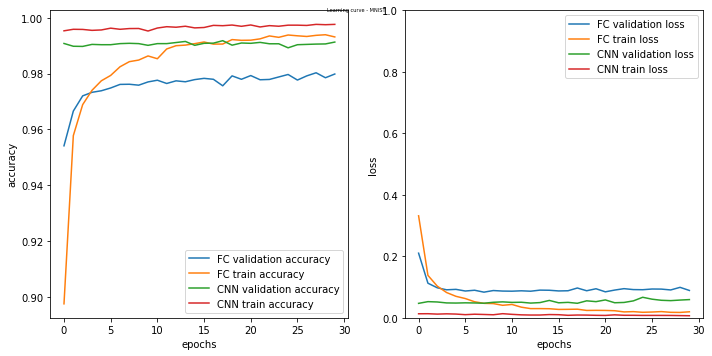

In [ ]:
# Learning curve
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(np.arange((len(FC.history['val_accuracy']))), FC.history['val_accuracy'], label='FC validation accuracy')
plt.plot(np.arange((len(FC.history['accuracy']))), FC.history['accuracy'], label='FC train accuracy')
plt.plot(np.arange((len(CNN.history['val_accuracy']))), CNN.history['val_accuracy'], label='CNN validation accuracy')
plt.plot(np.arange((len(CNN.history['accuracy']))), CNN.history['accuracy'], label='CNN train accuracy')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.subplot(1, 2, 2)
plt.plot(np.arange((len(FC.history['val_loss']))), FC.history['val_loss'], label='FC validation loss')
plt.plot(np.arange((len(FC.history['loss']))), FC.history['loss'], label='FC train loss')
plt.plot(np.arange((len(CNN.history['val_loss']))), CNN.history['val_loss'], label='CNN validation loss')
plt.plot(np.arange((len(CNN.history['loss']))), CNN.history['loss'], label='CNN train loss')
plt.legend(loc='best')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.suptitle('Learning curve - MNIST', fontsize=5)
plt.tight_layout()
plt.gca().set_ylim(0,1)
plt.show()

In [ ]:
model.evaluate(x_test, y_test)

313/313 [==============================] - 2s 4ms/step - loss: 0.0466 - accuracy: 0.9916


[0.0465703122317791, 0.991599977016449]

CNN shows better performance than conventional fully connected neural network